**Author**: Fabrizio Lucero Fernández. https://www.linkedin.com/in/fabrizio-lucero/

<font size="4.5">**Data Analytics in the Sports World: Assesing 2017/2018 English Premier League Data through Machine Learning and Passing Networks**</font>

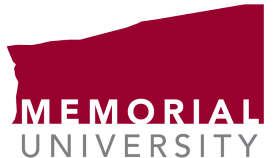

**Libraries:** For this notebook we first call the jupyter notebook where we have created all the functions used throughout the investigation. As usual practice we import pandas and numpy since we may be using them and also `networkx` for handling graphs. Lastly, `statsmodels` will help us with our final regression.

In [23]:
import import_ipynb
import definitions as ds
import pandas as pd
import numpy as np
import networkx as nx
import math
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns

<font size="5.5">**1. Preparing the data**</font>

Let's read the excel file with England EPL matches from 17-18 season.

In [2]:
df=pd.read_excel("Event EPL Dataset-1718.xlsx")

In order to avoid any mistakes, we create a copy to handle the data. We have made some modifications to some columns in order for them to be suitable for our created graph functions. 

>**Coordinates**: The coordinates have been multiplied to fit 120mx80m dimensions of the field that we retrieve from `mlp.soccer`. You can see more about this package in the following link: https://mplsoccer.readthedocs.io/en/latest/mplsoccer.pitch.html
<br>
>**Playing at home**: We created a 'Home_Away' Column differentiating with 1- for the Home team and 0- for the away team at every match. 
<br>
>**Filtered data**: we keep only columns that may be useful for this analysis ( More than welcome to change this selection if you want to go deeper on the analysis"
<br>


In [3]:
##General Wrangling
Events_df=df.copy()

#Transforming coordinates to match a football field meter dimension
Events_df[['start.x','start.y','finish.x','finish.y']]=Events_df[['start.x','start.y','finish.x','finish.y']].astype(float)


#For converting coordinates with 120 x80 m dimensions
Events_df[['start.x','finish.x']]=(Events_df[['start.x','finish.x']])*1.2
Events_df[['start.y','finish.y']]=((Events_df[['start.y','finish.y']]))*0.8


#Create a column to differentiate between local and visitor teams
Events_df['Home_Away']=np.where(Events_df['venue']==Events_df['local_stadium'],1,0)


#Keeping needed data. 
Events_df=Events_df.rename(columns={'name':'Position'})
Events_df=Events_df[['gameweek','dateutc','matchId','winner','matchPeriod','eventSec','teamId',
                     'officialName','Home_Away','playerId','shortName','Position','eventName',
                     'subEventName','Description','start.x','start.y','finish.x','finish.y']]


#Getting rid of Save attempts (feature caused by goals mainly - strong colinearity)
Events_df = Events_df[Events_df.eventName != 'Save attempt'].reset_index().drop('index',axis=1)

**Match Situations Function**
<br>
The following function uses the event dataset to do the following procedures: 
>**1. Create Goal counter**: Match every goal description with an accumulated counter that restarts itself for every match.
<br>
>**2. Compare situation**: if home team has more goals than the away team then home is winning and viceversa. Same score at the counter would mean the match is tied at that moment. 
<br>
*For more information you can see more detail at this link: 
<br>
https://github.com/fabriziolufe/GRI-Research---Passing-Networks/blob/main/definitions.ipynb*

In [4]:
Events_df=ds.Match_Situations(Events_df)

**Feature Training Importance Function**
The following function uses the event dataset to do the following procedures: 
>**1. Train and Test split**: We use our function `Transformation_ByOrder` to split the data. 
<br>
>**2. SGD Classifier**: Using this classifier ( you can try with different ones e.x: XGBOOST) we fit the model and obtain feature importances for every single match feature at the 3rd Level of detail. ***Event - SubEvent - Description.*** 
<br>
>**3. Merging Feature values into data**: we connect the feature value to our dataframe to give a score for every action. (How important it may be to the final result)
<br>
*For more information you can see more detail at this link:
<br>
https://github.com/fabriziolufe/GRI-Research---Passing-Networks/blob/main/definitions.ipynb*

In [5]:
#it will train the data with the first partition of the 2017-2018 competition ( First 19 matches.)
Events_df=ds.Feature_Training_Importance(Events_df)

Start Matchweek:  0.0 Final Matchweek:  19.0


<font size="5.5">**2. Performing Graph Networks**</font>

<font size="4.5">**2.1 For a specific match**</font>

**Match Graph Network Function:**
<br>
Creates and saves a event dataframe for selected match, and the graph objects of both teams. 
The following function has the following parameters: 
>**-Events_df**: The dataframe as input. 
<br>
<br>
>**-matchId**: 'int'. Match indicator for accesing the information of the selected match.
<br>
<br>
>**-matchperiod** (Default:'All'): 'string'.the portion of the match to be analyzed. '1H', '2H', 'All'.
<br>
<br>
>**-matchsituation** (Default:'All'): 'string'. the situation of the match to be analyzed. 'Home/Away Winning/Loosing', 'Game Tie', 'All'.
<br>
<br>
>**-Weight** (Default:'None'): 'string', the column of the dataframe that will be used as weight for differentiating between the importance of passes.
<br>
<br>
*For more information you can see more detail at this link:
<br>
https://github.com/fabriziolufe/GRI-Research---Passing-Networks/blob/main/definitions.ipynb*

In [6]:
#In this case we create our event dataframe, the Graph for home team and the away team for matchId 2499760 during the 1H. 
Dataframe,G_Home,G_Away=ds.Match_Graph_Network(Events_df, matchId=2499760,matchperiod='1H',matchsituation='All',
                                              Weight='Importance')

**Plot Pass Graph Network Function:**
<br>
Creates a visualization for a selected match, or a comparison for 2 teams during selected timeframes. It can also work to visualize a single team pass network if needed.
<br>
The following function has the following parameters: 
>**-Events_df**: The dataframe as input. 
<br>
<br>
>**-G_1**: 'object'. Graph object created for the home team./ or for the team you want to single-handly analyze.
<br>
<br>
>**-G_2**(Default:None): 'object'. Graph object created for the away team. Default set to 'None' ( as for analyzing just a single team performance).
<br>
<br>
>**-Visual** (Default:'1'): 'string'.Decide if you would like to see your first graph object visualization '1', or the second graph (G_2) visualization '2'. In case you want to see them together you can use 'Both'.
<br>
<br>
>**-Color_1** (Default:'red'): 'string'. Color for the G_1 Graph visualization
<br>
<br>
>**-Color_2** (Default:'blue'): 'string'. Color for the G_2 Graph visualization
<br>
<br>
>**-Weight_1** (Default:'None'): the object that encapsulates the measure to be applied to edges in the passing networks of G_1. If not weight is input it will create the graph in base of the number of passes between nodes. 'None'
<br>
<br>
>**-Weight_2** (Default:'None'): the object that encapsulates the measure to be applied to edges in the passing networks of G_2. If not weight is input it will create the graph in base of the number of passes between nodes. 'None'
<br>
<br>
>**-ColorMap_1** (Default:plt.cm.BuPu): Colormap for the G_1 Graph visualization of passes.
<br>
<br>
>**-ColorMap_2** (Default:plt.cm.BuGn): Colormap for the G_2 Graph visualization of passes.
<br>
<br>
*For more information you can see more detail at this link:
<br>
https://github.com/fabriziolufe/GRI-Research---Passing-Networks/blob/main/definitions.ipynb*

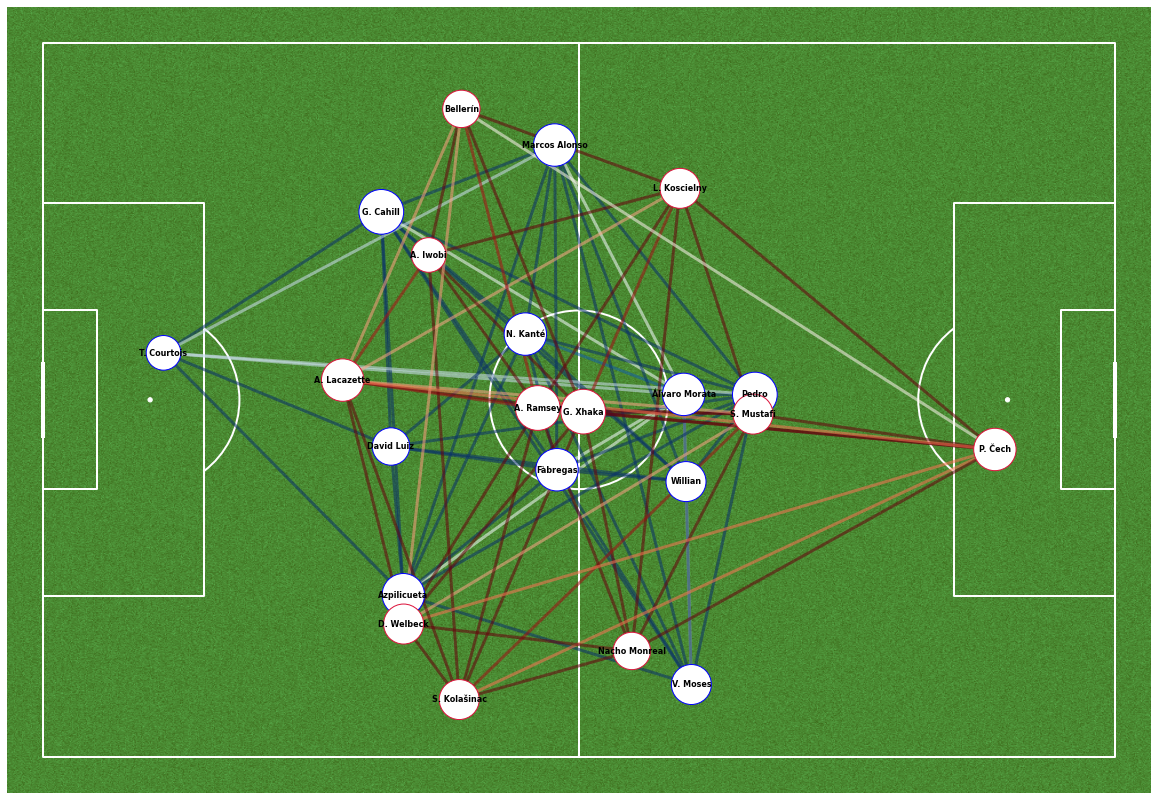

In [7]:
#Saving weight measuring for every edge created in order to give as input for the network plot
Importance_1 = [i['Importance'] for i in dict(G_Home.edges).values()]
Importance_2 = [i['Importance'] for i in dict(G_Away.edges).values()]

#Plot the visualization of both teams from the match selected before.
ds.Plot_Pass_Graph_Network(Dataframe,G_Home,G_Away,Visual='Both',Color_1='Blue',Color_2='crimson', 
                           Weight_1=Importance_1, Weight_2=Importance_2,
                           ColorMap_1=ds.plt.cm.Blues, ColorMap_2=ds.plt.cm.Reds)

<font size="5.5">**2.2 For a team's performance**</font>

In [8]:
#Let's give a look to the team id's for every team in the dataset...
Events_df[['teamId','officialName']].drop_duplicates().reset_index().drop('index',axis=1).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
teamId,1609,1631,1625,1651,1646,1610,1628,1673,1639,1623,1611,1633,1624,1613,10531,1619,1644,1612,1627,1659
officialName,Arsenal FC,Leicester City FC,Manchester City FC,Brighton & Hove Albion FC,Burnley FC,Chelsea FC,Crystal Palace FC,Huddersfield Town FC,Stoke City FC,Everton FC,Manchester United FC,West Ham United FC,Tottenham Hotspur FC,Newcastle United FC,Swansea City AFC,Southampton FC,Watford FC,Liverpool FC,West Bromwich Albion FC,AFC Bournemouth


**Team Graph Network Function:**
<br>
Creates and saves a event dataframe for selected match, and the graph objects of both teams. 
The following function has the following parameters: 
>**-Events_df**: The dataframe as input. 
<br>
<br>
>**-teamId**: 'int'. Team indicator for accesing the information of the selected team performance.
<br>
<br>
>**-Players**: 'string'. select if you like to analyze the 'Top 11' players with more features or the entire team sheet 'All'.
<br>
<br>
>**-At** (*Default:'Both'*): 'string'.the venue: 'Home', 'Away' or 'Both'.
<br>
<br>
>**-When** (*Default:'All'*): 'string'. the situation of the match for the team: 'Winning', 'Loosing','Tie' or 'All'.
<br>
<br>
>**-Gameweek_Origin** (*Default:1*): 'int', the gameweek where you would like to start the analysis. 
<br>
<br>
>**-Gameweek_End** (*Default:38*): 'int', the gameweek where you would like to end the analysis. 
<br>
<br>
>**-Weight** (*Default:'None'*): 'string', name of the column that has the weight for creating passes. If 'None' it would create them based on the frequency of edges between the nodes. 
<br>
<br>
*For more information you can see more detail at this link:
<br>
https://github.com/fabriziolufe/GRI-Research---Passing-Networks/blob/main/definitions.ipynb*

In [9]:
#Let's create the visualization for team 1611 - Manchester United. We'll select their top 11 during the entire season playing away.
Team_Events,G_Team=ds.Team_Graph_Network(Events_df, teamId=1611,Players='Top 11', matchperiod='All', At='Away',When='All',Gameweek_Origin=1,
                      Gameweek_End=38, Weight='Importance')

We now exemplify the use of `Plot_Pass_Graph_Network` for visualizing a single team analysis...

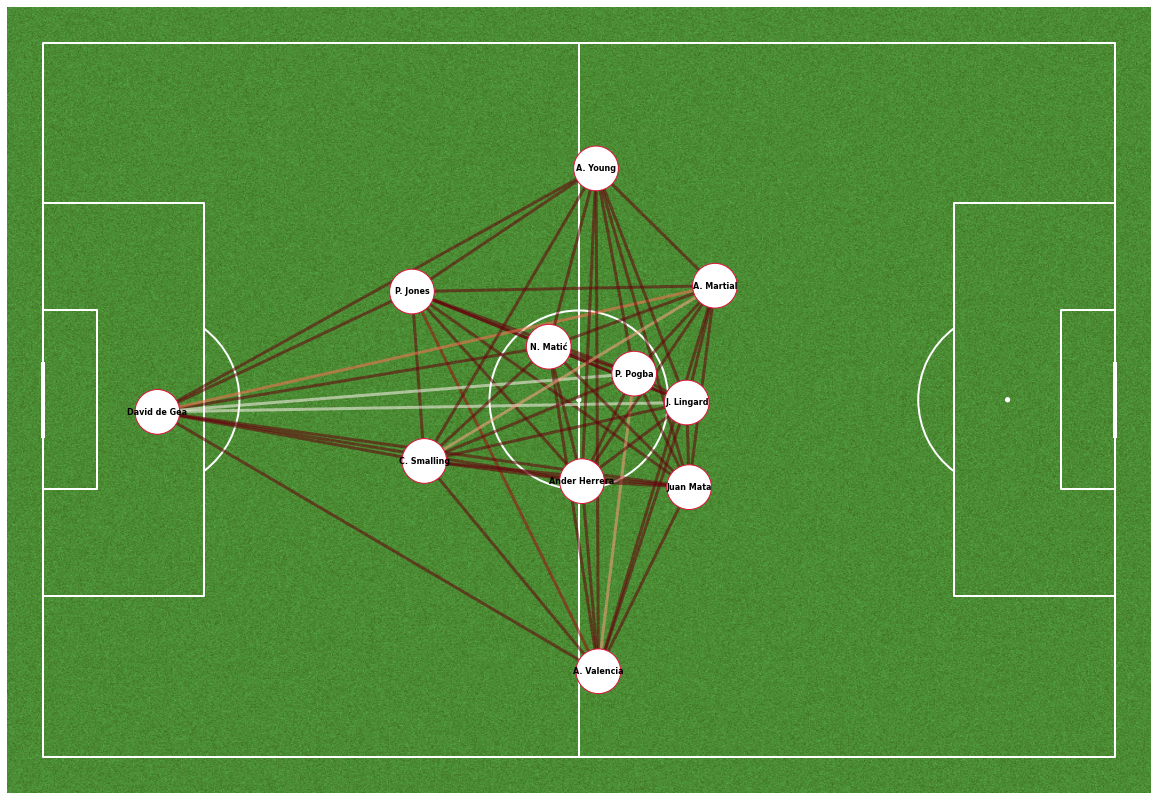

In [10]:
#Saving weight measuring for every edge created in order to give as input for the network plot
Importance_Team = [i['Importance'] for i in dict(G_Team.edges).values()]

#Plot the Man Utd events, selecting team color as 'crimson' and using the color map with .Reds
ds.Plot_Pass_Graph_Network(Team_Events,G_Team,Color_1='crimson', 
                           Weight_1=Importance_Team,
                           ColorMap_1=ds.plt.cm.Reds)

<font size="5.5">**3. Developing Metrics of Analysis**</font>

**Creating Passing Networks Metrics for every team - Assesing results.**

<font size="4.5">**3.1. Preparing data with generated graphs**</font>

networkx accounts for different algorithms that could be very useful when analyzing these graph objects. We have saw in the previous model prediction how passes by themselves can predict around 63-65% out match outcomes. Graph network let us see more deep into the analysis.
<br>
In this case, we are going to take a single metric: `average_node_connectivity()` measuring the grade of connection, this means of a reliable communication network between each node. for more information please visit: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.connectivity.average_node_connectivity.html

In [136]:
#We will create a dataframe containing only the team indicators and names for every match, including the winner of the match
Teams=Events_df[['matchId','teamId','officialName','winner']].drop_duplicates().reset_index().drop('index',axis=1)
Teams['win']=np.where(Teams['winner']==Teams['teamId'],1,0)
Teams=Teams.drop('winner',axis=1)


#now, we will iterate the result of the graph object for every team at every matchweek. 
index=0
Graph=[]
team=[]
teamId=[]
outcome=[]
matchId=[]
Connectivity=[]
for index in range(0,len(Teams.index)):
    team.append(Teams['officialName'][index])
    teamId.append(Teams['teamId'][index])
    outcome.append(Teams['win'][index])
    Graph.append(ds.Team_Graph_Network(Events_df, teamId=Teams['teamId'][index],Players='All', 
                                                   matchperiod='All', At='Both',When='All',
                                                   Gameweek_Origin=math.floor((20+index)/20), 
                                                   Gameweek_End=math.floor((20+index)/20),
                                                   Weight='Importance')[1])
    
#Also, we will create the connectivity indicator, to give us an example of a graph metric ( grade of connectivity between nodes)
    Connectivity.append(nx.average_node_connectivity(Graph[index]))
    index=index+1

#Save the results in a Dataframe.    
Graph_df = pd.DataFrame(list(zip(team,teamId,Graph,Connectivity,outcome)),
                   columns =['team','teamId', 'Graph Object','Connectivity','Outcome'])

#join the matchId to have a clear division of data for every match.
Graph_df=Graph_df.join(Teams['matchId'])

Let's see how the information we have retrieved looks like:

In [137]:
Graph_df.head()

,team,teamId,Graph Object,Connectivity,Outcome,matchId
0,Arsenal FC,1609,"(A. Lacazette, R. Holding, M. Özil, Mohamed El...",7.956044,1,2499719
1,Leicester City FC,1631,"(H. Maguire, M. Albrighton, W. Ndidi, C. Fuchs...",6.549451,0,2499719
2,Manchester City FC,1625,"(S. Agüero, Fernandinho, N. Otamendi, V. Kompa...",8.054945,1,2499720
3,Brighton & Hove Albion FC,1651,"(I. Brown, T. Hemed, D. Stephens, S. March, Br...",5.835165,0,2499720
4,Burnley FC,1646,"(J. Hendrick, J. Tarkowski, J. Cork, S. Ward, ...",7.064103,1,2499721


Now we have the connectivity grade for each team during a match. Despite this, for comparing a team `average_node_connectivity()` against it's opposition we will need to create an additional column that saves the information for the other team's `average_node_connectivity()` of an specific match.

In [138]:
#Create first temporal dataframe with one portion of teams ( playing at home)
Graph_df1=Graph_df.sort_values(by=['matchId','Outcome'],ascending=[True,False]).reset_index().drop('index',axis=1)
#Create second temporal dataframe with one portion of teams ( playing away)
Graph_df2=Graph_df.sort_values(by=['matchId','Outcome'],ascending=[True,True]).rename(columns={'Connectivity':'Connectivity Opp'}).reset_index().drop('index',axis=1)
#Join both dataframes
Graph_df=Graph_df1.join(Graph_df2['Connectivity Opp'])

#Last, let's create an indicator that substracts the team's connectivity with the opposition
Graph_df['Connectivity diff']=Graph_df['Connectivity']-Graph_df['Connectivity Opp']

<font size="4.5">**3.2. Grouping season information**</font>

In this stage, we aim to group the information for the season and compare it with real stats. 

In [147]:
#group every feature we created for every team during the season.
Connection=Graph_df.groupby(['team','teamId'])['Connectivity','Connectivity Opp','Connectivity diff'].sum()
#let's see it.
Connection=Connection.reset_index()

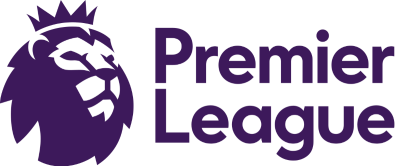
<br>
Here we will take a simple approach just by making out lists that contain information for every team actual stats. Such as points, goals, goals against and goal difference.

In [140]:
#taking team id's premier league stats in the league
points=[100,81,77,75,70,63,54,49,47,44,44,44,42,41,40,37,36,33,33,31]
goals=[106,68,74,84,62,74,36,44,56,39,45,45,48,44,34,28,37,28,35,31]
goalsagainst=[27,28,36,38,38,51,39,58,60,47,55,61,68,64,54,58,56,56,68,56]
goalsdiff=[79,40,38,46,4,23,-3,-14,-4,-8,-10,-16,-20,-20,-20,-30,-19,-28,-33,-25]
teamsid=[1625,1611,1624,1612,1610,1609,1646,1623,1631,1613,1628,1659,1633,1644,1651,1673,1619,10531,1639,1627]

Now, using **GOALS** as an example:

In [208]:
#generating a dataframe with the team Id and the goals by team.
teamsgoals=pd.DataFrame(list(zip(teamsid,goals)),
                   columns =['teamId', 'Goals'])

#Dataframe merging with the one that had our connectivity information for every team.
Results=pd.merge(Connection,teamsgoals,on='teamId',how='left')

#visualize final dataframe.
Results.sort_values(by='Connectivity diff',ascending=False)

,team,teamId,Connectivity,Connectivity Opp,Connectivity diff,Goals
10,Manchester City FC,1625,324.748918,264.594772,60.154146,106
16,Tottenham Hotspur FC,1624,307.232601,281.498002,25.734599,74
1,Arsenal FC,1609,312.777756,288.091242,24.686513,74
9,Liverpool FC,1612,307.712454,290.948052,16.764402,84
4,Chelsea FC,1610,306.677489,293.976357,12.701132,62
11,Manchester United FC,1611,302.470862,295.148185,7.322677,68
6,Everton FC,1623,297.600733,292.573260,5.027473,44
13,Southampton FC,1619,289.041292,291.988345,-2.947053,37
19,West Ham United FC,1633,288.204962,291.444389,-3.239427,48
8,Leicester City FC,1631,286.697636,290.301698,-3.604063,56


<font size="4.5">**3.3. Regression and comparison**</font>

Let's just replace the names without an underscore, for modelling purposes.

In [210]:
Results.columns = Results.columns.str.replace(' ','_')

We create a summary of a regression model to see how well does the connectivity difference between a team and his opposition can correlate with the amount of goals scored! 

In [150]:
Connectivity_lm = smf.ols(formula = 'Goals ~ Connectivity_diff', data=Results).fit()
Connectivity_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Goals   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     99.37
Date:                Wed, 03 Aug 2022   Prob (F-statistic):           9.38e-09
Time:                        13:14:11   Log-Likelihood:                -69.977
No. Observations:                  20   AIC:                             144.0
Df Residuals:                      18   BIC:                             145.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            50.9000      1.886     26.982      0.000      46.937      54.863
Connectivity_diff     0.9538      0.096      9.968      0.000       0.753       1.155
==============================================================================
Omnibus:                        0.093   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.955   Jarque-Bera (JB):                0.104
Skew:                          -0.096   Prob(JB):                        0.949
Kurtosis:                       2.702   Cond. No.                         19.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


<br>

The correlation is indeed **strong**. Goals scored can be explained in almost an 85% by the connectivity of a team during a match. 
<br>
<br>
Let's see how the teams divide themselves by this connectivity during the season with a scatter plot:

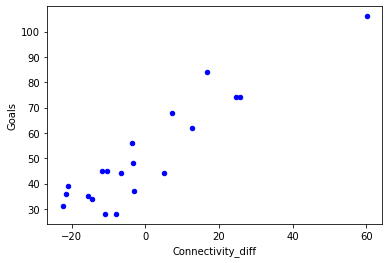

In [151]:
ax1 = Results.plot.scatter(y='Goals',x='Connectivity_diff',c='blue')

The graph clearly shows the positive tendency and a very interesting outlier at the top corner, **can you guess who that team it is?**

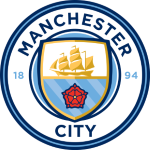

<font size="4.5">**3.4. Clustering for better understanding**</font>

The graph we left behind shows us the positive relationship between connectivity and goals scored. But, it will be nicer to see a division of the teams by this connectivity metric. We know the great outlier than Man City's 100 points title team was in 2017/2018, despite them: 
<br>
<br>
**How are teams clustered by their connectivity and points achieved?**

We are going to use the "Elbow Method" in this occasion to see what would be the appropiate number of clusters for the data. As O'REILLY states: 
<br>
>"if k increases, average distortion will decrease, each cluster will have fewer constituent instances, and the instances will be closer to their respective centroids. However, the improvements in average distortion will decline as k increases. The value of k at which improvement in distortion declines the most is called the elbow, at which we should stop dividing the data into further clusters"

<br>
For more info, visit this link:
<br>
https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml


**Elbow Method**

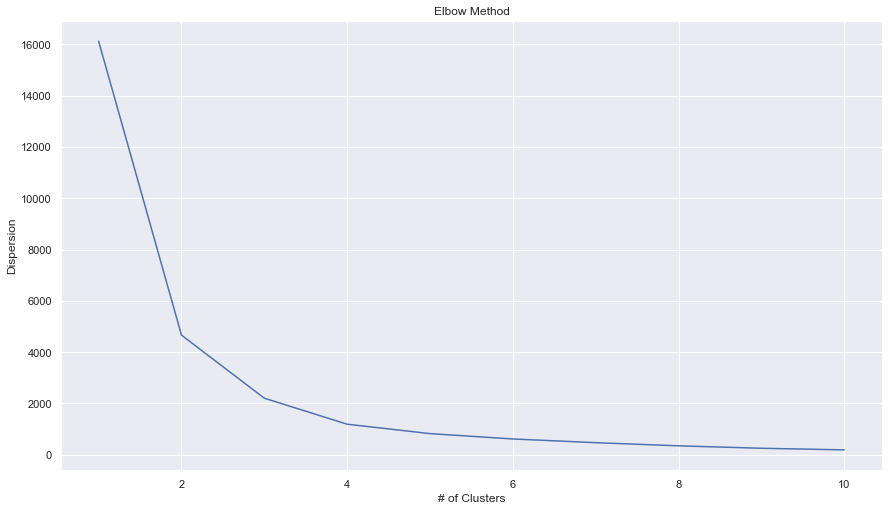

In [224]:
#Filtering to have the data for clustering.
Cluster_df=Results[['team','teamId','Connectivity_diff','Goals']]
dispersion=[]
#iterating by k clusters from 1 to 10.
for index in range (1,11):
    km=KMeans(n_clusters=index,
    init='k-means++',max_iter=300, n_init=10)
    km.fit(Cluster_df[['Connectivity_diff','Goals']])
    dispersion.append(km.inertia_)
    
#Ploting the Elbow Method Graph    
ds.plt.plot(range(1,11),dispersion)   
ds.plt.title('Elbow Method')
ds.plt.xlabel("# of Clusters")
ds.plt.ylabel('Dispersion')
ds.plt.show()

Basically, the slope at clusters 3 and 4, tend to decrease as further k number of cluster increases. So let's try partitioning the data into 3 segments. 

**DBSCAN Clustering**

In order to have a more accurate division of data into groups we are applying the use of DBSCAN analysis: A more intuitive approach that is deeper explained in the following link: 
<br> 
https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf

In [225]:
#let's assign the DBSCAN with 10 eps ( distance ) and the minimum samples around.
DBS=DBSCAN(eps=10,min_samples=4)


#fit the data for clustering
labels=DBS.fit_predict(Cluster_df[['Connectivity_diff','Goals']])


#Lastly, changing the cluster labels, in this case 3 clusters are generated so we assigned names for them.
labels=labels.astype(str)
labels.tolist()
labels = list(map(lambda x: x.replace('-1', 'Big Six'), labels))
labels = list(map(lambda x: x.replace('0', 'Mid Table'), labels))
labels = list(map(lambda x: x.replace('1', 'Bottom of the League'), labels))

In this occasion, it will be of great advantage to visualize the name of the teams after the clustering analysis. For this approach we are going to use `seaborn` to assign `hue=labels` and add text for each point of data. 
<br>
Let's see the results!

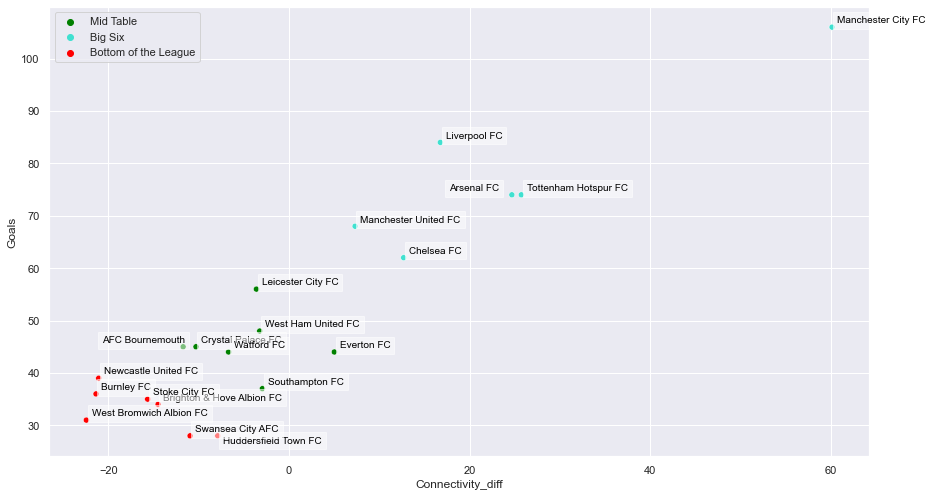

In [244]:
#Using seaborn and plotting connectivity against goals scored. A palette is assigned for each cluster. 
sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.scatterplot(x="Connectivity_diff", y="Goals", hue=labels, data=Cluster_df, palette=['green', "turquoise", "red"])

#You can try to run the code without this further conditionals. They are solely to visualize better some text labels in the plot.
for index in range(Cluster_df.shape[0]):
    
    if(Cluster_df['teamId'][index]==1609):
        ds.plt.text(x=Cluster_df.Connectivity_diff[index]-7,y=Cluster_df.Goals[index]+0.8,s=Cluster_df.team[index], 
                     fontdict=dict(color='black',size=10),
                     bbox=dict(facecolor='white',alpha=0.5))
    
    else:
        if(Cluster_df['teamId'][index]==1659):
            ds.plt.text(x=Cluster_df.Connectivity_diff[index]-9,y=Cluster_df.Goals[index]+0.8,s=Cluster_df.team[index], 
                     fontdict=dict(color='black',size=10),
                     bbox=dict(facecolor='white',alpha=0.5))
        else:
            if(Cluster_df['teamId'][index]==1673):
                ds.plt.text(x=Cluster_df.Connectivity_diff[index]+0.6,y=Cluster_df.Goals[index]-1.4,s=Cluster_df.team[index], 
                     fontdict=dict(color='black',size=10),
                     bbox=dict(facecolor='white',alpha=0.5))
            else:
                ds.plt.text(x=Cluster_df.Connectivity_diff[index]+0.6,y=Cluster_df.Goals[index]+0.8,s=Cluster_df.team[index], 
                     fontdict=dict(color='black',size=10),
                     bbox=dict(facecolor='white',alpha=0.5))

We can clearly observe 3 clusters of data. Let's remember that goals aren't 100% related with the final position in the table, that's why Newcastle United (with 44 points in the actual competition - mid table.) seemed to overperform West Ham United ( 42 points - Bottom of the league) in the clustering division. Despite that, is amazing how the 6 teams with overall greater `average_node_connectivity` are the inmaculate Big Six of the Premier League, with a clear difference to the record breaker title holder: Manchester City! 

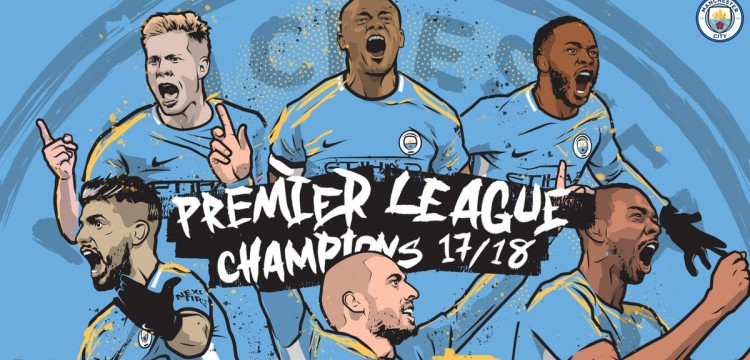

**Link to Original Dataset documentation**:
    https://figshare.com/collections/Soccer_match_event_dataset/4415000/5

**Published article from where Dataset was retrieved**:
Pappalardo, L., Cintia, P., Rossi, A., Massucco, E., Ferragina, P., Pedreschi, D., &amp; Giannotti, F. (2019). A public data  set of spatio-temporal match events in soccer competitions. Scientific Data, 6(1). https://doi.org/10.1038/s41597-019-0247-7 